In [6]:
import pandas as pd
import numpy as np
from sklearn.impute import KNNImputer
from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from xgboost import XGBRegressor
from prophet import Prophet
import matplotlib.pyplot as plt

# Load the data
data_path = 'data_inverter_tn.csv'
data = pd.read_csv(data_path)

# Preview the data
print("Initial Data Preview:")
print(data.head())

# Convert the 'sent_date' to datetime format
data['sent_date'] = pd.to_datetime(data['sent_date'])

# Save a copy of the initial data
data_initial_copy = data.copy()

# Separate non-numeric columns
non_numeric_cols = ['sent_date', 'CRC16']
numeric_data = data.drop(columns=non_numeric_cols)

# Clean and convert data types for numeric columns
for column in numeric_data.columns:
    if numeric_data[column].dtype == 'object':
        numeric_data[column] = numeric_data[column].str.replace(',', '')
        numeric_data[column] = pd.to_numeric(numeric_data[column], errors='coerce')

# Save a copy after initial cleaning
data_cleaned_copy = numeric_data.copy()


Initial Data Preview:
       id  device_id  A  AphaA  AphaB  AphaC  PPVphAB  PPVphBC  PPVphCA  \
0  726165        155  0      5      5      5        0        0        0   
1  726168        155  0      6      6      6        0        0        0   
2  726171        155  0      8      8      8        0        0        0   
3  726174        155  0     11     10     11        0        0        0   
4  726176        155  0     11     11     11        0        0        0   

   PPVphA  ...  Evt2  EvtVnd1  EvtVnd2  EvtVnd3  EvtVnd4  TmSrc  Tms  CRC16  \
0     234  ...     0        0        0        0        0      0    0   e602   
1     234  ...     0        0        0        0        0      0    0   d64a   
2     235  ...     0        0        0        0        0      0    0   a518   
3     234  ...     0        0        0        0        0      0    0   b5ea   
4     234  ...     0        0        0        0        0      0    0   60ac   

             sent_date  transaction_date  
0  2022-0

In [7]:
# Function to process data in batches
def batch_impute(data, batch_size=10000):
    n_batches = len(data) // batch_size + int(len(data) % batch_size != 0)
    imputed_batches = []

    for i in range(n_batches):
        batch = data.iloc[i * batch_size:(i + 1) * batch_size]
        imputer = KNNImputer(n_neighbors=5)
        imputed_batch = imputer.fit_transform(batch)
        
        # Check the shape of the batch to ensure it matches the expected number of columns
        if imputed_batch.shape[1] != data.shape[1]:
            raise ValueError("Column mismatch after imputation in batch processing.")
        
        imputed_batches.append(imputed_batch)
        
        # Print progress
        print(f"Processed batch {i+1}/{n_batches}")

    return np.vstack(imputed_batches)

# Handling missing values using KNN Imputer in batches for numeric data
print("\nHandling missing values in batches...")
data_imputed_numeric = batch_impute(numeric_data)

# Convert back to DataFrame
data_imputed_numeric = pd.DataFrame(data_imputed_numeric, columns=numeric_data.columns)

# Combine imputed numeric data with non-numeric data
data_imputed = pd.concat([data_imputed_numeric, data[non_numeric_cols].reset_index(drop=True)], axis=1)

# Save a copy after imputation
data_imputed_copy = data_imputed.copy()



Handling missing values in batches...
Processed batch 1/50
Processed batch 2/50
Processed batch 3/50
Processed batch 4/50
Processed batch 5/50
Processed batch 6/50
Processed batch 7/50
Processed batch 8/50
Processed batch 9/50
Processed batch 10/50
Processed batch 11/50
Processed batch 12/50
Processed batch 13/50
Processed batch 14/50
Processed batch 15/50
Processed batch 16/50
Processed batch 17/50
Processed batch 18/50
Processed batch 19/50
Processed batch 20/50
Processed batch 21/50
Processed batch 22/50
Processed batch 23/50
Processed batch 24/50
Processed batch 25/50
Processed batch 26/50
Processed batch 27/50
Processed batch 28/50
Processed batch 29/50
Processed batch 30/50
Processed batch 31/50
Processed batch 32/50
Processed batch 33/50
Processed batch 34/50
Processed batch 35/50
Processed batch 36/50
Processed batch 37/50
Processed batch 38/50
Processed batch 39/50
Processed batch 40/50
Processed batch 41/50
Processed batch 42/50
Processed batch 43/50
Processed batch 44/50
Pr

In [8]:
# Removing Outliers
print("\nRemoving outliers...")
iso_forest = IsolationForest(contamination=0.01)
outliers = iso_forest.fit_predict(data_imputed_numeric)
data_cleaned = data_imputed_numeric[outliers == 1]

# Save a copy after removing outliers
data_cleaned_copy = data_cleaned.copy()

# Normalizing Data
print("\nNormalizing the data...")
scaler = MinMaxScaler()
data_normalized = pd.DataFrame(scaler.fit_transform(data_cleaned), columns=data_cleaned.columns)

# Save a copy after normalization
data_normalized_copy = data_normalized.copy()



Removing outliers...

Normalizing the data...


In [9]:
# Define features and lags
features = data_normalized.columns
lags = [1, 2, 3]
windows = [3, 7, 14]

# Create lag and rolling features
def create_lag_features(df, lags, column):
    for lag in lags:
        df[f'{column}_lag_{lag}'] = df[column].shift(lag)
    return df

def create_rolling_features(df, windows, column):
    for window in windows:
        df[f'{column}_roll_mean_{window}'] = df[column].rolling(window=window).mean()
        df[f'{column}_roll_std_{window}'] = df[column].rolling(window=window).std()
    return df

print("\nCreating lag and rolling features for the train data...")
for feature in features:
    data_normalized = create_lag_features(data_normalized, lags, feature)
    data_normalized = create_rolling_features(data_normalized, windows, feature)

# Dropping NaN values caused by lag/rolling features
data_normalized.dropna(inplace=True)

# Save a copy after feature engineering
data_feature_engineered_copy = data_normalized.copy()

# Assuming the data has a datetime column named 'sent_date'
data_normalized['sent_date'] = pd.to_datetime(data_imputed['sent_date'])
data_normalized.sort_values('sent_date', inplace=True)

# Splitting data
train_data = data_normalized[data_normalized['sent_date'] < '2022-12-01']
test_data = data_normalized[data_normalized['sent_date'] >= '2022-12-01']

# Save copies of train and test data before dropping columns
train_data_copy = train_data.copy()
test_data_copy = test_data.copy()

# Drop the 'sent_date' and 'CRC16' columns as they are not features
train_data = train_data.drop(columns=['sent_date'])
test_data = test_data.drop(columns=['sent_date'])

# Checking the head of the train and test data
print("\nTrain Data:")
print(train_data.head())
print("\nTest Data:")
print(test_data.head())



Creating lag and rolling features for the train data...


/var/folders/m7/4z7bg8rd1b530s_xvwr091nm0000gn/T/ipykernel_78638/2716958871.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[f'{column}_lag_{lag}'] = df[column].shift(lag)
/var/folders/m7/4z7bg8rd1b530s_xvwr091nm0000gn/T/ipykernel_78638/2716958871.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[f'{column}_lag_{lag}'] = df[column].shift(lag)
/var/folders/m7/4z7bg8rd1b530s_xvwr091nm0000gn/T/ipykernel_78638/2716958871.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `fram


Train Data:
          id  device_id    A     AphaA     AphaB     AphaC  PPVphAB  PPVphBC  \
13  0.007718        0.0  0.0  0.003052  0.003052  0.003052      0.0      0.0   
14  0.007723        0.0  0.0  0.003052  0.003052  0.003052      0.0      0.0   
15  0.007727        0.0  0.0  0.002746  0.002746  0.002746      0.0      0.0   
16  0.007732        0.0  0.0  0.002746  0.002746  0.002746      0.0      0.0   
17  0.007736        0.0  0.0  0.002746  0.002746  0.002746      0.0      0.0   

    PPVphCA    PPVphA  ...  Tms_roll_std_14  transaction_date_lag_1  \
13      0.0  0.963115  ...              0.0                0.004763   
14      0.0  0.963115  ...              0.0                0.004765   
15      0.0  0.963115  ...              0.0                0.004767   
16      0.0  0.963115  ...              0.0                0.004768   
17      0.0  0.963115  ...              0.0                0.004770   

    transaction_date_lag_2  transaction_date_lag_3  \
13                0.00476

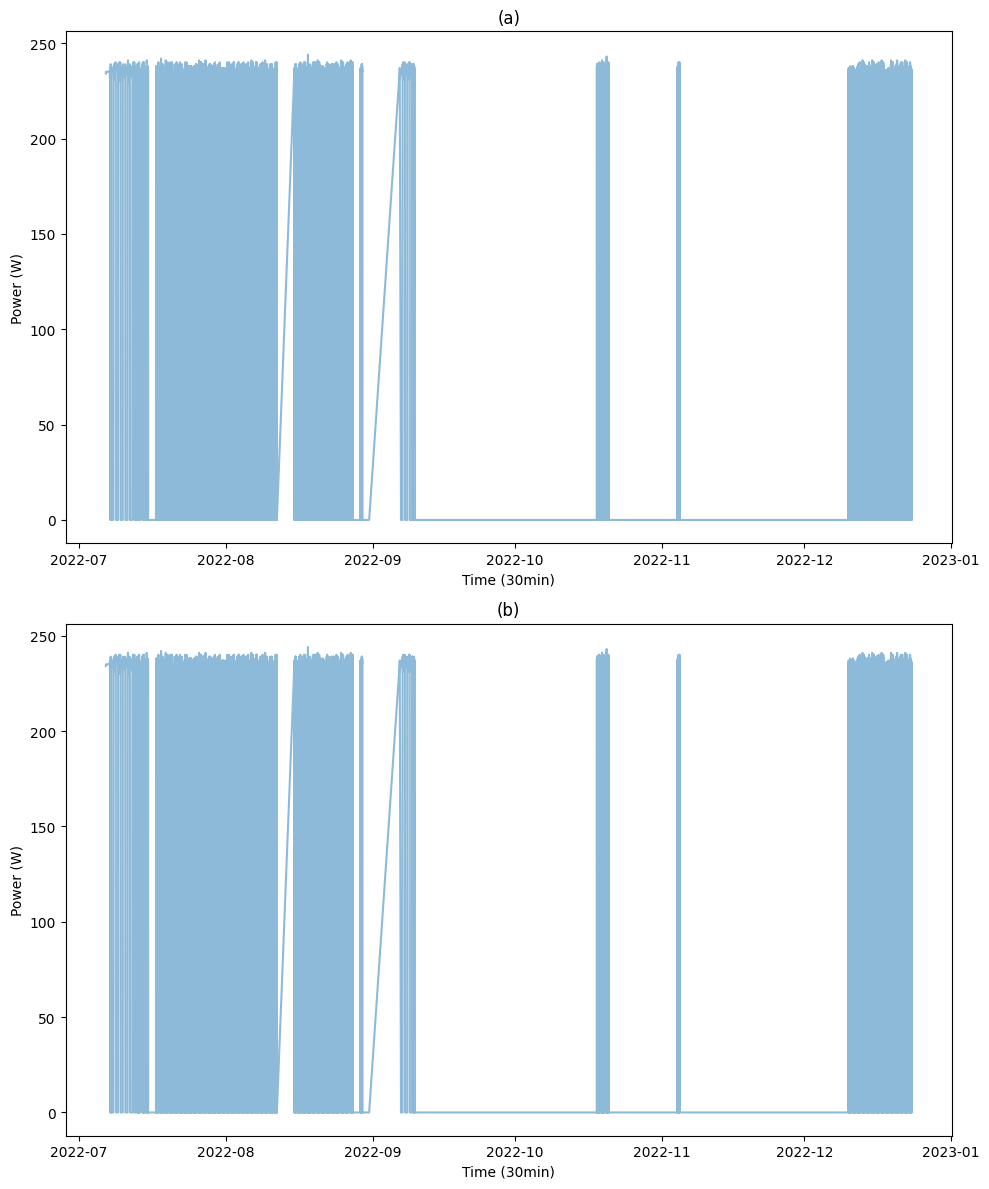

In [10]:
# Plotting the data
fig, axs = plt.subplots(2, 1, figsize=(10, 12))

# Plot a
axs[0].plot(data['sent_date'], data['PPVphA'], alpha=0.5)
axs[0].set_title('(a)', loc='center')
axs[0].set_xlabel('Time (30min)')
axs[0].set_ylabel('Power (W)')

# Plot b
axs[1].plot(data['sent_date'], data['PPVphA'], alpha=0.5)
axs[1].set_title('(b)', loc='center')
axs[1].set_xlabel('Time (30min)')
axs[1].set_ylabel('Power (W)')

plt.tight_layout()
plt.show()


In [15]:
import tensorflow as tf
import tensorflow 

/Users/mango/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:34: NotOpenSSLWarning: urllib3 v2.0 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


In [14]:
!pip3 install pandas numpy scikit-learn xgboost prophet matplotlib
!pip3 install keras-tcn


Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip is available: 24.1.2 -> 24.2
[notice] To update, run: /Library/Developer/CommandLineTools/usr/bin/python3 -m pip install --upgrade pip
Defaulting to user installation because normal site-packages is not writeable
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.6/12.6 MB 6.7 MB/s eta 0:00:0000:0100:01

[notice] A new release of pip is available: 24.1.2 -> 24.2
[notice] To update, run: /Library/Developer/CommandLineTools/usr/bin/python3 -m pip install --upgrade pip


Initial Data Preview:
       id  device_id  A  AphaA  AphaB  AphaC  PPVphAB  PPVphBC  PPVphCA  \
0  726165        155  0      5      5      5        0        0        0   
1  726168        155  0      6      6      6        0        0        0   
2  726171        155  0      8      8      8        0        0        0   
3  726174        155  0     11     10     11        0        0        0   
4  726176        155  0     11     11     11        0        0        0   

   PPVphA  ...  Evt2  EvtVnd1  EvtVnd2  EvtVnd3  EvtVnd4  TmSrc  Tms  CRC16  \
0     234  ...     0        0        0        0        0      0    0   e602   
1     234  ...     0        0        0        0        0      0    0   d64a   
2     235  ...     0        0        0        0        0      0    0   a518   
3     234  ...     0        0        0        0        0      0    0   b5ea   
4     234  ...     0        0        0        0        0      0    0   60ac   

             sent_date  transaction_date  
0  2022-0

/var/folders/m7/4z7bg8rd1b530s_xvwr091nm0000gn/T/ipykernel_78638/1125688621.py:102: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[f'{column}_lag_{lag}'] = df[column].shift(lag)
/var/folders/m7/4z7bg8rd1b530s_xvwr091nm0000gn/T/ipykernel_78638/1125688621.py:102: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[f'{column}_lag_{lag}'] = df[column].shift(lag)
/var/folders/m7/4z7bg8rd1b530s_xvwr091nm0000gn/T/ipykernel_78638/1125688621.py:102: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling


Train Data:
          id  device_id    A     AphaA     AphaB     AphaC  PPVphAB  PPVphBC  \
13  0.007718        0.0  0.0  0.003052  0.003052  0.003052      0.0      0.0   
14  0.007723        0.0  0.0  0.003052  0.003052  0.003052      0.0      0.0   
15  0.007727        0.0  0.0  0.002746  0.002746  0.002746      0.0      0.0   
16  0.007732        0.0  0.0  0.002746  0.002746  0.002746      0.0      0.0   
17  0.007736        0.0  0.0  0.002746  0.002746  0.002746      0.0      0.0   

    PPVphCA    PPVphA  ...  Tms_roll_std_14  transaction_date_lag_1  \
13      0.0  0.963115  ...              0.0                0.004763   
14      0.0  0.963115  ...              0.0                0.004765   
15      0.0  0.963115  ...              0.0                0.004767   
16      0.0  0.963115  ...              0.0                0.004768   
17      0.0  0.963115  ...              0.0                0.004770   

    transaction_date_lag_2  transaction_date_lag_3  \
13                0.00476

15:34:22 - cmdstanpy - INFO - Chain [1] start processing
15:36:59 - cmdstanpy - INFO - Chain [1] done processing


Prophet RMSE: 5447618192.352795, MAE: 4562831523.841635, R2: -2.736152063110591e+28
XGBoost RMSE: 0.009305820933757342, MAE: 0.006891701572861832, R2: 0.9996205667786434


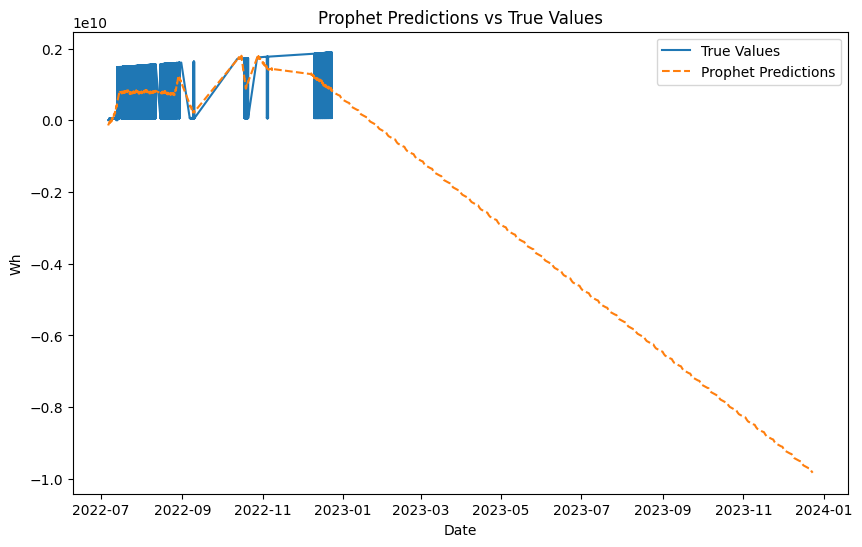

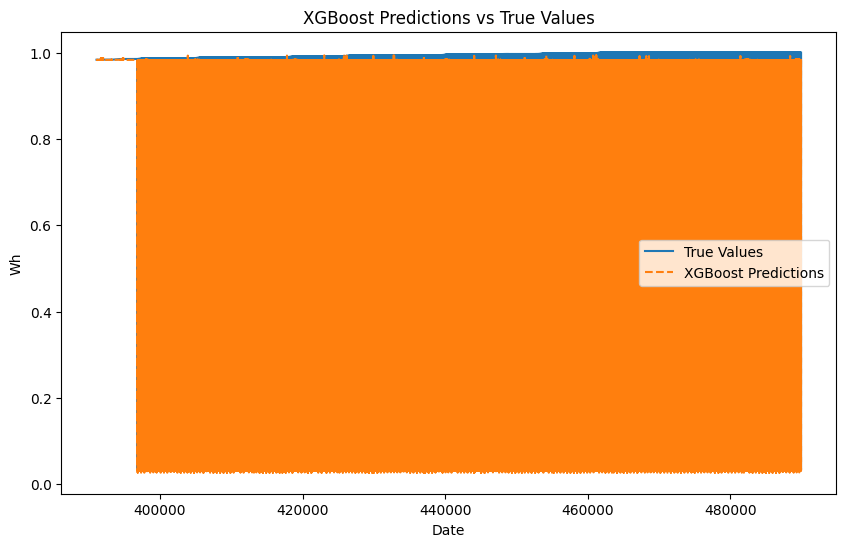

Epoch 1/50
12221/12221 [==============================] - 49s 4ms/step - loss: 0.0096
Epoch 2/50
12221/12221 [==============================] - 48s 4ms/step - loss: 0.0082
Epoch 3/50
12221/12221 [==============================] - 46s 4ms/step - loss: 0.0079
Epoch 4/50
12221/12221 [==============================] - 46s 4ms/step - loss: 0.0079
Epoch 5/50
12221/12221 [==============================] - 57s 5ms/step - loss: 0.0078
Epoch 6/50
12221/12221 [==============================] - 46s 4ms/step - loss: 0.0077
Epoch 7/50
12221/12221 [==============================] - 45s 4ms/step - loss: 0.0077
Epoch 8/50
12221/12221 [==============================] - 46s 4ms/step - loss: 0.0077
Epoch 9/50
12221/12221 [==============================] - 47s 4ms/step - loss: 0.0076
Epoch 10/50
12221/12221 [==============================] - 46s 4ms/step - loss: 0.0076
Epoch 11/50
12221/12221 [==============================] - 46s 4ms/step - loss: 0.0076
Epoch 12/50
12221/12221 [===========================

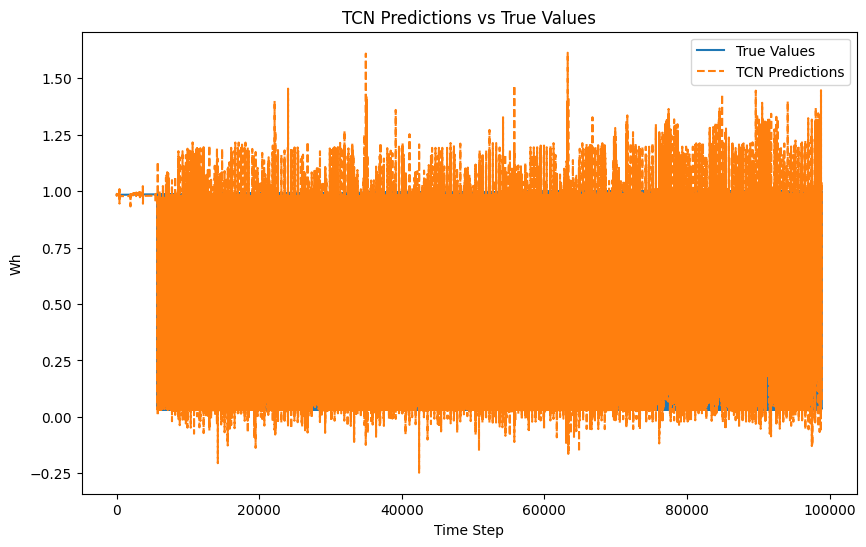

ValueError: all the input array dimensions except for the concatenation axis must match exactly, but along dimension 0, the array at index 0 has size 365 and the array at index 1 has size 98860

In [29]:
import pandas as pd
import numpy as np
from sklearn.impute import KNNImputer
from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from xgboost import XGBRegressor
from prophet import Prophet
import matplotlib.pyplot as plt
from tcn import TCN
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

# Load the data
data_path = 'data_inverter_tn.csv'
data = pd.read_csv(data_path)

# Preview the data
print("Initial Data Preview:")
print(data.head())

# Convert the 'sent_date' to datetime format
data['sent_date'] = pd.to_datetime(data['sent_date'])

# Save a copy of the initial data
data_initial_copy = data.copy()

# Separate non-numeric columns
non_numeric_cols = ['sent_date', 'CRC16']
numeric_data = data.drop(columns=non_numeric_cols)

# Clean and convert data types for numeric columns
for column in numeric_data.columns:
    if numeric_data[column].dtype == 'object':
        numeric_data[column] = numeric_data[column].str.replace(',', '')
        numeric_data[column] = pd.to_numeric(numeric_data[column], errors='coerce')

# Save a copy after initial cleaning
data_cleaned_copy = numeric_data.copy()

# Function to process data in batches
def batch_impute(data, batch_size=10000):
    n_batches = len(data) // batch_size + int(len(data) % batch_size != 0)
    imputed_batches = []

    for i in range(n_batches):
        batch = data.iloc[i * batch_size:(i + 1) * batch_size]
        imputer = KNNImputer(n_neighbors=5)
        imputed_batch = imputer.fit_transform(batch)
        
        # Check the shape of the batch to ensure it matches the expected number of columns
        if imputed_batch.shape[1] != data.shape[1]:
            raise ValueError("Column mismatch after imputation in batch processing.")
        
        imputed_batches.append(imputed_batch)
        
        # Print progress
        print(f"Processed batch {i+1}/{n_batches}")

    return np.vstack(imputed_batches)

# Handling missing values using KNN Imputer in batches for numeric data
print("\nHandling missing values in batches...")
data_imputed_numeric = batch_impute(numeric_data)

# Convert back to DataFrame
data_imputed_numeric = pd.DataFrame(data_imputed_numeric, columns=numeric_data.columns)

# Combine imputed numeric data with non-numeric data
data_imputed = pd.concat([data_imputed_numeric, data[non_numeric_cols].reset_index(drop=True)], axis=1)

# Save a copy after imputation
data_imputed_copy = data_imputed.copy()

# Removing Outliers
print("\nRemoving outliers...")
iso_forest = IsolationForest(contamination=0.01)
outliers = iso_forest.fit_predict(data_imputed_numeric)
data_cleaned = data_imputed_numeric[outliers == 1]

# Save a copy after removing outliers
data_cleaned_copy = data_cleaned.copy()

# Normalizing Data
print("\nNormalizing the data...")
scaler = MinMaxScaler()
data_normalized = pd.DataFrame(scaler.fit_transform(data_cleaned), columns=data_cleaned.columns)

# Save a copy after normalization
data_normalized_copy = data_normalized.copy()

# Define features and lags
features = data_normalized.columns
lags = [1, 2, 3]
windows = [3, 7, 14]

# Create lag and rolling features
def create_lag_features(df, lags, column):
    for lag in lags:
        df[f'{column}_lag_{lag}'] = df[column].shift(lag)
    return df

def create_rolling_features(df, windows, column):
    for window in windows:
        df[f'{column}_roll_mean_{window}'] = df[column].rolling(window=window).mean()
        df[f'{column}_roll_std_{window}'] = df[column].rolling(window=window).std()
    return df

print("\nCreating lag and rolling features for the train data...")
for feature in features:
    data_normalized = create_lag_features(data_normalized, lags, feature)
    data_normalized = create_rolling_features(data_normalized, windows, feature)

# Dropping NaN values caused by lag/rolling features
data_normalized.dropna(inplace=True)

# Save a copy after feature engineering
data_feature_engineered_copy = data_normalized.copy()

# Assuming the data has a datetime column named 'sent_date'
data_normalized['sent_date'] = pd.to_datetime(data_imputed['sent_date'])
data_normalized.sort_values('sent_date', inplace=True)

# Splitting data
train_data = data_normalized[data_normalized['sent_date'] < '2022-12-01']
test_data = data_normalized[data_normalized['sent_date'] >= '2022-12-01']

# Save copies of train and test data before dropping columns
train_data_copy = train_data.copy()
test_data_copy = test_data.copy()

# Drop the 'sent_date' columns as they are not features
train_data = train_data.drop(columns=['sent_date'])
test_data = test_data.drop(columns=['sent_date'])

# Checking the head of the train and test data
print("\nTrain Data:")
print(train_data.head())
print("\nTest Data:")
print(test_data.head())

# Prepare training data
X_train = train_data.drop(['Wh'], axis=1)
y_train = train_data['Wh']

# Prepare testing data
X_test = test_data.drop(['Wh'], axis=1)
y_test = test_data['Wh']

# Model 1: Prophet
prophet_data = pd.DataFrame({'ds': data_imputed['sent_date'], 'y': data_imputed['Wh']})
prophet_model = Prophet()
prophet_model.fit(prophet_data)

# Adjust the number of future periods to a manageable number
future_periods = min(len(test_data), 365) 
future = prophet_model.make_future_dataframe(periods=future_periods)
forecast = prophet_model.predict(future)
prophet_predictions = forecast['yhat'].values[-future_periods:]

# Model 2: XGBoost
xgb_model = XGBRegressor(n_estimators=1000, learning_rate=0.01)
xgb_model.fit(X_train, y_train)
xgb_predictions = xgb_model.predict(X_test)

# Model Evaluation
# Evaluating Prophet
prophet_rmse = np.sqrt(mean_squared_error(y_test[:future_periods], prophet_predictions))
prophet_mae = mean_absolute_error(y_test[:future_periods], prophet_predictions)
prophet_r2 = r2_score(y_test[:future_periods], prophet_predictions)

# Evaluating XGBoost
xgb_rmse = np.sqrt(mean_squared_error(y_test, xgb_predictions))
xgb_mae = mean_absolute_error(y_test, xgb_predictions)
xgb_r2 = r2_score(y_test, xgb_predictions)

print(f"Prophet RMSE: {prophet_rmse}, MAE: {prophet_mae}, R2: {prophet_r2}")
print(f"XGBoost RMSE: {xgb_rmse}, MAE: {xgb_mae}, R2: {xgb_r2}")

# Visualizing Prophet Predictions
fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(data_imputed['sent_date'], data_imputed['Wh'], label='True Values')
ax.plot(forecast['ds'], forecast['yhat'], label='Prophet Predictions', linestyle='--')
ax.set_title('Prophet Predictions vs True Values')
ax.set_xlabel('Date')
ax.set_ylabel('Wh')
ax.legend()
plt.show()

# Visualizing XGBoost Predictions
fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(test_data.index, y_test, label='True Values')
ax.plot(test_data.index, xgb_predictions, label='XGBoost Predictions', linestyle='--')
ax.set_title('XGBoost Predictions vs True Values')
ax.set_xlabel('Date')
ax.set_ylabel('Wh')
ax.legend()
plt.show()

# Model 3: Temporal Convolutional Network (TCN)
from tcn import TCN

# Prepare the data for TCN
def create_tcn_input(data, target, window_size):
    X, y = [], []
    for i in range(len(data) - window_size):
        X.append(data[i:i + window_size])
        y.append(target[i + window_size])
    return np.array(X), np.array(y)

window_size = 10
X_train_tcn, y_train_tcn = create_tcn_input(X_train.values, y_train.values, window_size)
X_test_tcn, y_test_tcn = create_tcn_input(X_test.values, y_test.values, window_size)

# Define TCN model
model_tcn = Sequential([
    TCN(input_shape=(window_size, X_train.shape[1]), dilations=[1, 2, 4]),
    Dense(1)
])

model_tcn.compile(optimizer='adam', loss='mean_squared_error')
model_tcn.fit(X_train_tcn, y_train_tcn, epochs=50, batch_size=32, verbose=1)

# Predictions with TCN
tcn_predictions = model_tcn.predict(X_test_tcn).flatten()

# Evaluating TCN
tcn_rmse = np.sqrt(mean_squared_error(y_test_tcn, tcn_predictions))
tcn_mae = mean_absolute_error(y_test_tcn, tcn_predictions)
tcn_r2 = r2_score(y_test_tcn, tcn_predictions)

print(f"TCN RMSE: {tcn_rmse}, MAE: {tcn_mae}, R2: {tcn_r2}")

# Visualizing TCN Predictions
fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(range(len(y_test_tcn)), y_test_tcn, label='True Values')
ax.plot(range(len(y_test_tcn)), tcn_predictions, label='TCN Predictions', linestyle='--')
ax.set_title('TCN Predictions vs True Values')
ax.set_xlabel('Time Step')
ax.set_ylabel('Wh')
ax.legend()
plt.show()

# Combine predictions for ensembling
ensemble_predictions = np.column_stack((prophet_predictions[:len(y_test)], xgb_predictions))
ensemble_model = LinearRegression()
ensemble_model.fit(ensemble_predictions, y_test[:len(ensemble_predictions)])
final_predictions = ensemble_model.predict(ensemble_predictions)

# Evaluation of the ensemble model
ensemble_rmse = np.sqrt(mean_squared_error(y_test[:len(final_predictions)], final_predictions))
ensemble_mae = mean_absolute_error(y_test[:len(final_predictions)], final_predictions)
ensemble_r2 = r2_score(y_test[:len(final_predictions)], final_predictions)

print(f"Ensemble RMSE: {ensemble_rmse}, MAE: {ensemble_mae}, R2: {ensemble_r2}")

# Visualizing Ensemble Predictions
fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(test_data.index, y_test, label='True Values')
ax.plot(test_data.index[:len(final_predictions)], final_predictions, label='Ensemble Predictions', linestyle='--')
ax.set_title('Ensemble Predictions vs True Values')
ax.set_xlabel('Date')
ax.set_ylabel('Wh')
ax.legend()
plt.show()

# Visualizing Prophet Predictions with normalization
fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(data_imputed['sent_date'], data_imputed['Wh'] / data_imputed['Wh'].max(), label='True Values (normalized)')
ax.plot(forecast['ds'], forecast['yhat'] / forecast['yhat'].max(), label='Prophet Predictions (normalized)', linestyle='--')
ax.set_title('Prophet Predictions vs True Values (Normalized)')
ax.set_xlabel('Date')
ax.set_ylabel('Normalized Wh')
ax.legend()
plt.show()

# Visualizing XGBoost Predictions with normalization
fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(test_data.index, y_test / y_test.max(), label='True Values (normalized)')
ax.plot(test_data.index, xgb_predictions / xgb_predictions.max(), label='XGBoost Predictions (normalized)', linestyle='--')
ax.set_title('XGBoost Predictions vs True Values (Normalized)')
ax.set_xlabel('Date')
ax.set_ylabel('Normalized Wh')
ax.legend()
plt.show()

# Visualizing TCN Predictions with normalization
fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(range(len(y_test_tcn)), y_test_tcn / y_test_tcn.max(), label='True Values (normalized)')
ax.plot(range(len(y_test_tcn)), tcn_predictions / tcn_predictions.max(), label='TCN Predictions (normalized)', linestyle='--')
ax.set_title('TCN Predictions vs True Values (Normalized)')
ax.set_xlabel('Time Step')
ax.set_ylabel('Normalized Wh')
ax.legend()
plt.show()

# Visualizing Ensemble Predictions with normalization
fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(test_data.index, y_test / y_test.max(), label='True Values (normalized)')
ax.plot(test_data.index[:len(final_predictions)], final_predictions / final_predictions.max(), label='Ensemble Predictions (normalized)', linestyle='--')
ax.set_title('Ensemble Predictions vs True Values (Normalized)')
ax.set_xlabel('Date')
ax.set_ylabel('Normalized Wh')
ax.legend()
plt.show()

# Add season and time of day columns
def get_season(date):
    month = date.month
    if month in [12, 1, 2]:
        return 'Winter'
    elif month in [3, 4, 5]:
        return 'Spring'
    elif month in [6, 7, 8]:
        return 'Summer'
    else:
        return 'Autumn'

def get_time_of_day(date):
    hour = date.hour
    if 5 <= hour < 12:
        return 'Morning'
    elif 12 <= hour < 17:
        return 'Afternoon'
    elif 17 <= hour < 21:
        return 'Evening'
    else:
        return 'Night'

data_imputed['season'] = data_imputed['sent_date'].apply(get_season)
data_imputed['time_of_day'] = data_imputed['sent_date'].apply(get_time_of_day)

# Save the updated dataset
data_imputed.to_csv('data_imputed_with_season_and_time.csv', index=False)
print("Data with season and time of day columns added and saved.")

# Analysis based on time of day
time_of_day_avg = data_imputed.groupby('time_of_day')['Wh'].mean()
fig, ax = plt.subplots(figsize=(10, 6))
time_of_day_avg.plot(kind='bar', ax=ax, title='Average Energy Output by Time of Day')
ax.set_xlabel('Time of Day')
ax.set_ylabel('Average Wh')
plt.show()

# Analysis based on season
season_avg = data_imputed.groupby('season')['Wh'].mean()
fig, ax = plt.subplots(figsize=(10, 6))
season_avg.plot(kind='bar', ax=ax, title='Average Energy Output by Season')
ax.set_xlabel('Season')
ax.set_ylabel('Average Wh')
plt.show()

# Analyzing energy output at different times of the day
data_imputed['hour'] = pd.to_datetime(data_imputed['sent_date']).dt.hour
hourly_data = data_imputed.groupby('hour')['Wh'].mean()

# Plotting average energy output by hour
fig, ax = plt.subplots(figsize=(10, 6))
hourly_data.plot(kind='bar', ax=ax)
ax.set_title('Average Energy Output by Hour of the Day')
ax.set_xlabel('Hour of the Day')
ax.set_ylabel('Average Wh')
plt.show()

# Further analysis can include average energy output by month
data_imputed['month'] = pd.to_datetime(data_imputed['sent_date']).dt.month
monthly_data = data_imputed.groupby('month')['Wh'].mean()

# Plotting average energy output by month
fig, ax = plt.subplots(figsize=(10, 6))
monthly_data.plot(kind='bar', ax=ax)
ax.set_title('Average Energy Output by Month')
ax.set_xlabel('Month')
ax.set_ylabel('Average Wh')
plt.show()

# Save the final dataset with all changes
data_imputed.to_csv('final_data_with_all_changes.csv', index=False)
print("Final data with all changes saved.")



In [22]:
!pip3 install pyemd


Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip is available: 24.1.2 -> 24.2
[notice] To update, run: /Library/Developer/CommandLineTools/usr/bin/python3 -m pip install --upgrade pip


In [30]:
import pandas as pd
import numpy as np
from sklearn.impute import KNNImputer
from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import MinMaxScaler

# Load the data
data_path = 'data_inverter_tn.csv'
data = pd.read_csv(data_path)

# Preview the data
print("Initial Data Preview:")
print(data.head())

# Convert the 'sent_date' to datetime format
data['sent_date'] = pd.to_datetime(data['sent_date'])

# Save a copy of the initial data
data_initial_copy = data.copy()

# Separate non-numeric columns
non_numeric_cols = ['sent_date', 'CRC16']
numeric_data = data.drop(columns=non_numeric_cols)

# Clean and convert data types for numeric columns
for column in numeric_data.columns:
    if numeric_data[column].dtype == 'object':
        numeric_data[column] = numeric_data[column].str.replace(',', '')
        numeric_data[column] = pd.to_numeric(numeric_data[column], errors='coerce')

# Save a copy after initial cleaning
data_cleaned_copy = numeric_data.copy()

# Function to process data in batches
def batch_impute(data, batch_size=10000):
    n_batches = len(data) // batch_size + int(len(data) % batch_size != 0)
    imputed_batches = []

    for i in range(n_batches):
        batch = data.iloc[i * batch_size:(i + 1) * batch_size]
        imputer = KNNImputer(n_neighbors=5)
        imputed_batch = imputer.fit_transform(batch)
        
        # Check the shape of the batch to ensure it matches the expected number of columns
        if imputed_batch.shape[1] != data.shape[1]:
            raise ValueError("Column mismatch after imputation in batch processing.")
        
        imputed_batches.append(imputed_batch)
        
        # Print progress
        print(f"Processed batch {i+1}/{n_batches}")

    return np.vstack(imputed_batches)

# Handling missing values using KNN Imputer in batches for numeric data
print("\nHandling missing values in batches...")
data_imputed_numeric = batch_impute(numeric_data)

# Convert back to DataFrame
data_imputed_numeric = pd.DataFrame(data_imputed_numeric, columns=numeric_data.columns)

# Combine imputed numeric data with non-numeric data
data_imputed = pd.concat([data_imputed_numeric, data[non_numeric_cols].reset_index(drop=True)], axis=1)

# Save a copy after imputation
data_imputed_copy = data_imputed.copy()

# Removing Outliers
print("\nRemoving outliers...")
iso_forest = IsolationForest(contamination=0.01)
outliers = iso_forest.fit_predict(data_imputed_numeric)
data_cleaned = data_imputed_numeric[outliers == 1]

# Save a copy after removing outliers
data_cleaned_copy = data_cleaned.copy()

# Normalizing Data
print("\nNormalizing the data...")
scaler = MinMaxScaler()
data_normalized = pd.DataFrame(scaler.fit_transform(data_cleaned), columns=data_cleaned.columns)

# Save a copy after normalization
data_normalized_copy = data_normalized.copy()

# Define features and lags
features = data_normalized.columns
lags = [1, 2, 3]
windows = [3, 7, 14]

# Create lag and rolling features
def create_lag_features(df, lags, column):
    for lag in lags:
        df[f'{column}_lag_{lag}'] = df[column].shift(lag)
    return df

def create_rolling_features(df, windows, column):
    for window in windows:
        df[f'{column}_roll_mean_{window}'] = df[column].rolling(window=window).mean()
        df[f'{column}_roll_std_{window}'] = df[column].rolling(window=window).std()
    return df

print("\nCreating lag and rolling features for the train data...")
for feature in features:
    data_normalized = create_lag_features(data_normalized, lags, feature)
    data_normalized = create_rolling_features(data_normalized, windows, feature)

# Dropping NaN values caused by lag/rolling features
data_normalized.dropna(inplace=True)

# Save a copy after feature engineering
data_feature_engineered_copy = data_normalized.copy()

# Assuming the data has a datetime column named 'sent_date'
data_normalized['sent_date'] = pd.to_datetime(data_imputed['sent_date'])
data_normalized.sort_values('sent_date', inplace=True)

# Splitting data
train_data = data_normalized[data_normalized['sent_date'] < '2022-12-01']
test_data = data_normalized[data_normalized['sent_date'] >= '2022-12-01']

# Save copies of train and test data before dropping columns
train_data_copy = train_data.copy()
test_data_copy = test_data.copy()

# Drop the 'sent_date' columns as they are not features
train_data = train_data.drop(columns=['sent_date'])
test_data = test_data.drop(columns=['sent_date'])

# Checking the head of the train and test data
print("\nTrain Data:")
print(train_data.head())
print("\nTest Data:")
print(test_data.head())


Initial Data Preview:
       id  device_id  A  AphaA  AphaB  AphaC  PPVphAB  PPVphBC  PPVphCA  \
0  726165        155  0      5      5      5        0        0        0   
1  726168        155  0      6      6      6        0        0        0   
2  726171        155  0      8      8      8        0        0        0   
3  726174        155  0     11     10     11        0        0        0   
4  726176        155  0     11     11     11        0        0        0   

   PPVphA  ...  Evt2  EvtVnd1  EvtVnd2  EvtVnd3  EvtVnd4  TmSrc  Tms  CRC16  \
0     234  ...     0        0        0        0        0      0    0   e602   
1     234  ...     0        0        0        0        0      0    0   d64a   
2     235  ...     0        0        0        0        0      0    0   a518   
3     234  ...     0        0        0        0        0      0    0   b5ea   
4     234  ...     0        0        0        0        0      0    0   60ac   

             sent_date  transaction_date  
0  2022-0

/var/folders/m7/4z7bg8rd1b530s_xvwr091nm0000gn/T/ipykernel_78638/744678652.py:93: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[f'{column}_lag_{lag}'] = df[column].shift(lag)
/var/folders/m7/4z7bg8rd1b530s_xvwr091nm0000gn/T/ipykernel_78638/744678652.py:93: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[f'{column}_lag_{lag}'] = df[column].shift(lag)
/var/folders/m7/4z7bg8rd1b530s_xvwr091nm0000gn/T/ipykernel_78638/744678652.py:93: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `fram


Train Data:
          id  device_id    A     AphaA     AphaB     AphaC  PPVphAB  PPVphBC  \
13  0.007718        0.0  0.0  0.003052  0.003052  0.003052      0.0      0.0   
14  0.007723        0.0  0.0  0.003052  0.003052  0.003052      0.0      0.0   
15  0.007727        0.0  0.0  0.002746  0.002746  0.002746      0.0      0.0   
16  0.007732        0.0  0.0  0.002746  0.002746  0.002746      0.0      0.0   
17  0.007736        0.0  0.0  0.002746  0.002746  0.002746      0.0      0.0   

    PPVphCA    PPVphA  ...  Tms_roll_std_14  transaction_date_lag_1  \
13      0.0  0.963115  ...              0.0                0.004763   
14      0.0  0.963115  ...              0.0                0.004765   
15      0.0  0.963115  ...              0.0                0.004767   
16      0.0  0.963115  ...              0.0                0.004768   
17      0.0  0.963115  ...              0.0                0.004770   

    transaction_date_lag_2  transaction_date_lag_3  \
13                0.00476

In [31]:
# Add season and time of day columns
def get_season(date):
    month = date.month
    if month in [12, 1, 2]:
        return 'Winter'
    elif month in [3, 4, 5]:
        return 'Spring'
    elif month in [6, 7, 8]:
        return 'Summer'
    else:
        return 'Autumn'

def get_time_of_day(date):
    hour = date.hour
    if 5 <= hour < 12:
        return 'Morning'
    elif 12 <= hour < 17:
        return 'Afternoon'
    elif 17 <= hour < 21:
        return 'Evening'
    else:
        return 'Night'

data_imputed['season'] = data_imputed['sent_date'].apply(get_season)
data_imputed['time_of_day'] = data_imputed['sent_date'].apply(get_time_of_day)

# Save the updated dataset
data_imputed.to_csv('data_imputed_with_season_and_time.csv', index=False)
print("Data with season and time of day columns added and saved.")


Data with season and time of day columns added and saved.


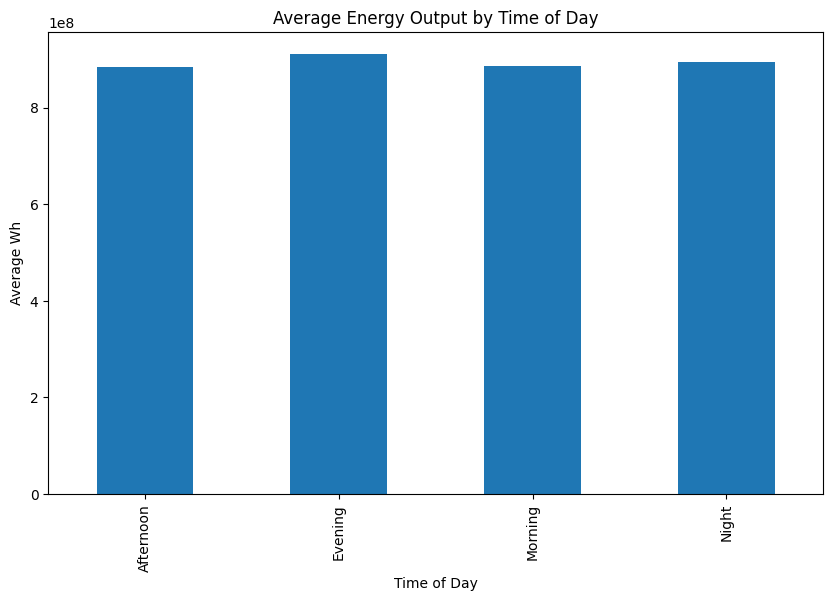

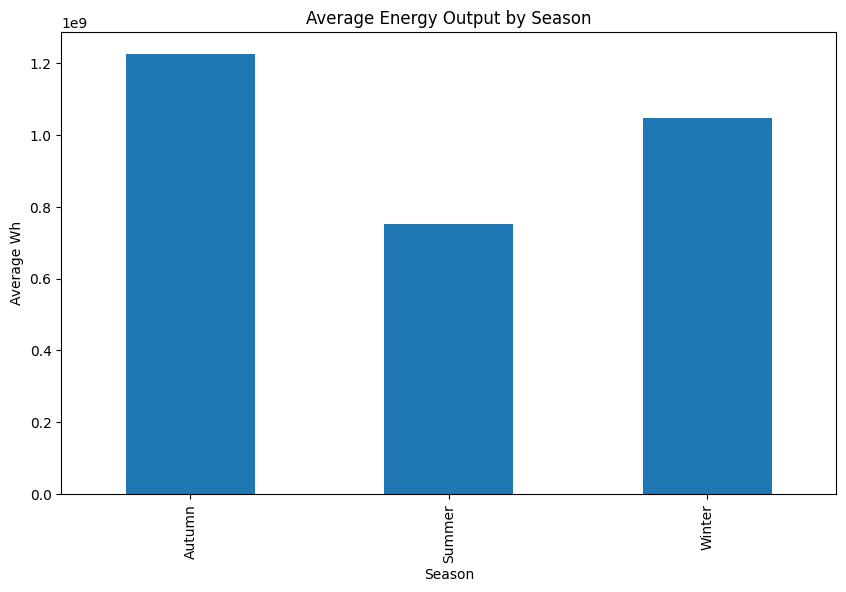

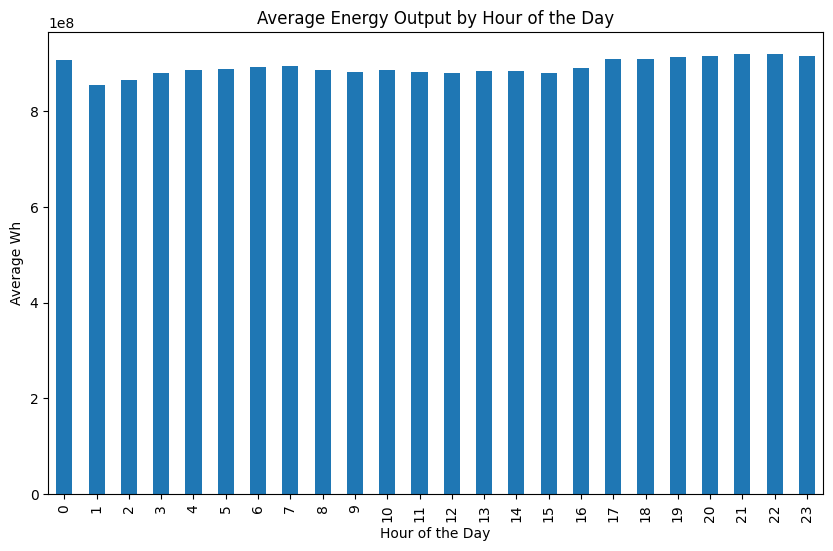

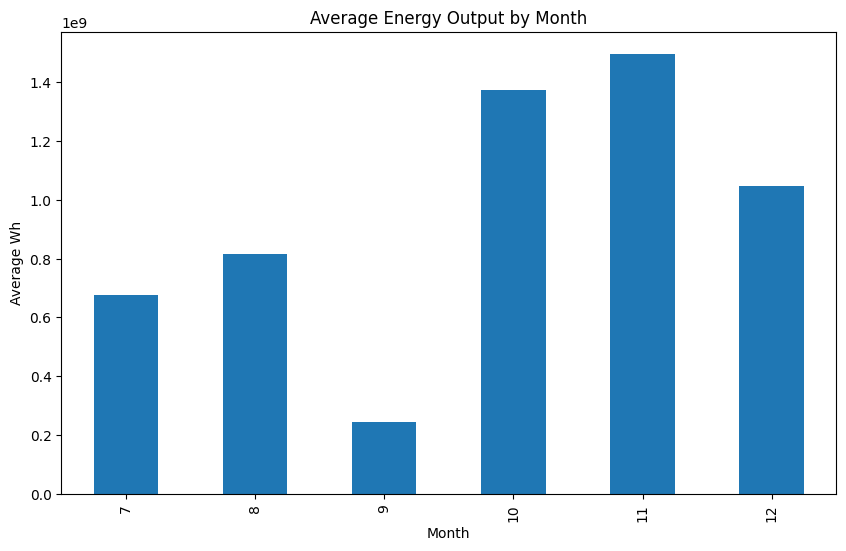

In [32]:
import matplotlib.pyplot as plt

# Analysis based on time of day
time_of_day_avg = data_imputed.groupby('time_of_day')['Wh'].mean()
fig, ax = plt.subplots(figsize=(10, 6))
time_of_day_avg.plot(kind='bar', ax=ax, title='Average Energy Output by Time of Day')
ax.set_xlabel('Time of Day')
ax.set_ylabel('Average Wh')
plt.show()

# Analysis based on season
season_avg = data_imputed.groupby('season')['Wh'].mean()
fig, ax = plt.subplots(figsize=(10, 6))
season_avg.plot(kind='bar', ax=ax, title='Average Energy Output by Season')
ax.set_xlabel('Season')
ax.set_ylabel('Average Wh')
plt.show()

# Analyzing energy output at different times of the day
data_imputed['hour'] = pd.to_datetime(data_imputed['sent_date']).dt.hour
hourly_data = data_imputed.groupby('hour')['Wh'].mean()

# Plotting average energy output by hour
fig, ax = plt.subplots(figsize=(10, 6))
hourly_data.plot(kind='bar', ax=ax)
ax.set_title('Average Energy Output by Hour of the Day')
ax.set_xlabel('Hour of the Day')
ax.set_ylabel('Average Wh')
plt.show()

# Further analysis can include average energy output by month
data_imputed['month'] = pd.to_datetime(data_imputed['sent_date']).dt.month
monthly_data = data_imputed.groupby('month')['Wh'].mean()

# Plotting average energy output by month
fig, ax = plt.subplots(figsize=(10, 6))
monthly_data.plot(kind='bar', ax=ax)
ax.set_title('Average Energy Output by Month')
ax.set_xlabel('Month')
ax.set_ylabel('Average Wh')
plt.show()



In [33]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from xgboost import XGBRegressor
from prophet import Prophet
import matplotlib.pyplot as plt
from tcn import TCN
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

# Prepare training data
X_train = train_data.drop(['Wh'], axis=1)
y_train = train_data['Wh']

# Prepare testing data
X_test = test_data.drop(['Wh'], axis=1)
y_test = test_data['Wh']


In [4]:

!pip3 install pyemd
!pip3 install EMD-signal

Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip is available: 24.1.2 -> 24.2
[notice] To update, run: /Library/Developer/CommandLineTools/usr/bin/python3 -m pip install --upgrade pip
Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip is available: 24.1.2 -> 24.2
[notice] To update, run: /Library/Developer/CommandLineTools/usr/bin/python3 -m pip install --upgrade pip


In [9]:
from PyEMD import EEMD
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tcn import TCN
from prophet import Prophet
import matplotlib.pyplot as plt

# Function to decompose data using EEMD
def eemd_decomposition(data, column, num_imfs=3):
    eemd = EEMD()
    imfs = eemd.eemd(data[column].values)
    imfs = imfs[:num_imfs]
    return imfs

# Decompose the 'Wh' column
imfs = eemd_decomposition(data_imputed, 'Wh')

# Create DataFrame with IMFs
imf_data = pd.DataFrame(imfs.T, columns=[f'IMF_{i+1}' for i in range(imfs.shape[0])])
imf_data['sent_date'] = data_imputed['sent_date']

# Split IMFs into train and test sets
train_imf = imf_data[imf_data['sent_date'] < '2022-12-01']
test_imf = imf_data[imf_data['sent_date'] >= '2022-12-01']

# Drop the 'sent_date' column
train_imf = train_imf.drop(columns=['sent_date'])
test_imf = test_imf.drop(columns=['sent_date'])

# TCN model for each IMF
def create_tcn_model(input_shape):
    model = Sequential([
        TCN(input_shape=input_shape, dilations=[1, 2, 4]),
        Dense(1)
    ])
    model.compile(optimizer='adam', loss='mean_squared_error')
    return model

# Prepare the data for TCN
def create_tcn_input(data, target, window_size):
    X, y = [], []
    for i in range(len(data) - window_size):
        X.append(data[i:i + window_size])
        y.append(target[i + window_size])
    return np.array(X), np.array(y)

window_size = 10
tcn_predictions_list = []

# Train TCN for each IMF and collect predictions
for i in range(imfs.shape[0]):
    X_train_imf, y_train_imf = create_tcn_input(train_imf.values, train_data['Wh'].values, window_size)
    X_test_imf, y_test_imf = create_tcn_input(test_imf.values, test_data['Wh'].values, window_size)
    
    model_tcn = create_tcn_model((window_size, X_train_imf.shape[2]))
    model_tcn.fit(X_train_imf, y_train_imf, epochs=50, batch_size=32, verbose=1)
    
    tcn_predictions = model_tcn.predict(X_test_imf).flatten()
    tcn_predictions_list.append(tcn_predictions)

# Combine TCN predictions
combined_tcn_predictions = np.sum(tcn_predictions_list, axis=0)

# Prophet model for residuals
residuals = test_data['Wh'].values[window_size:] - combined_tcn_predictions
prophet_data = pd.DataFrame({'ds': test_data['sent_date'].iloc[window_size:], 'y': residuals})
prophet_model = Prophet()
prophet_model.fit(prophet_data)

# Predict residuals using Prophet
future = prophet_model.make_future_dataframe(periods=len(residuals))
forecast = prophet_model.predict(future)
prophet_residual_predictions = forecast['yhat'].values

# Final predictions
final_predictions = combined_tcn_predictions + prophet_residual_predictions

# Evaluating the model
rmse = np.sqrt(mean_squared_error(test_data['Wh'].values[window_size:], final_predictions))
mae = mean_absolute_error(test_data['Wh'].values[window_size:], final_predictions)
r2 = r2_score(test_data['Wh'].values[window_size:], final_predictions)

print(f"EEMD-TCN-Prophet RMSE: {rmse}, MAE: {mae}, R2: {r2}")

# Visualizing EEMD-TCN-Prophet Predictions
fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(test_data['sent_date'].iloc[window_size:], test_data['Wh'].values[window_size:], label='True Values')
ax.plot(test_data['sent_date'].iloc[window_size:], final_predictions, label='EEMD-TCN-Prophet Predictions', linestyle='--')
ax.set_title('EEMD-TCN-Prophet Predictions vs True Values')
ax.set_xlabel('Date')
ax.set_ylabel('Wh')
ax.legend()
plt.show()


ImportError: cannot import name 'EEMD' from 'PyEMD' (/Users/mango/Desktop/Thesis/PyEMD/__init__.py)

In [8]:
!pip3 uninstall pyemd
!pip3 uninstall PyEMD


Found existing installation: pyemd 1.0.0
Uninstalling pyemd-1.0.0:
  Would remove:
    /Users/mango/Library/Python/3.9/lib/python/site-packages/pyemd-1.0.0.dist-info/*
    /Users/mango/Library/Python/3.9/lib/python/site-packages/pyemd/*
  Would not remove (might be manually added):
    /Users/mango/Library/Python/3.9/lib/python/site-packages/pyemd/BEMD.py
    /Users/mango/Library/Python/3.9/lib/python/site-packages/pyemd/CEEMDAN.py
    /Users/mango/Library/Python/3.9/lib/python/site-packages/pyemd/EEMD.py
    /Users/mango/Library/Python/3.9/lib/python/site-packages/pyemd/EMD.py
    /Users/mango/Library/Python/3.9/lib/python/site-packages/pyemd/EMD2d.py
    /Users/mango/Library/Python/3.9/lib/python/site-packages/pyemd/EMD_matlab.py
    /Users/mango/Library/Python/3.9/lib/python/site-packages/pyemd/checks.py
    /Users/mango/Library/Python/3.9/lib/python/site-packages/pyemd/compact.py
    /Users/mango/Library/Python/3.9/lib/python/site-packages/pyemd/experimental/__init__.py
    /Users/

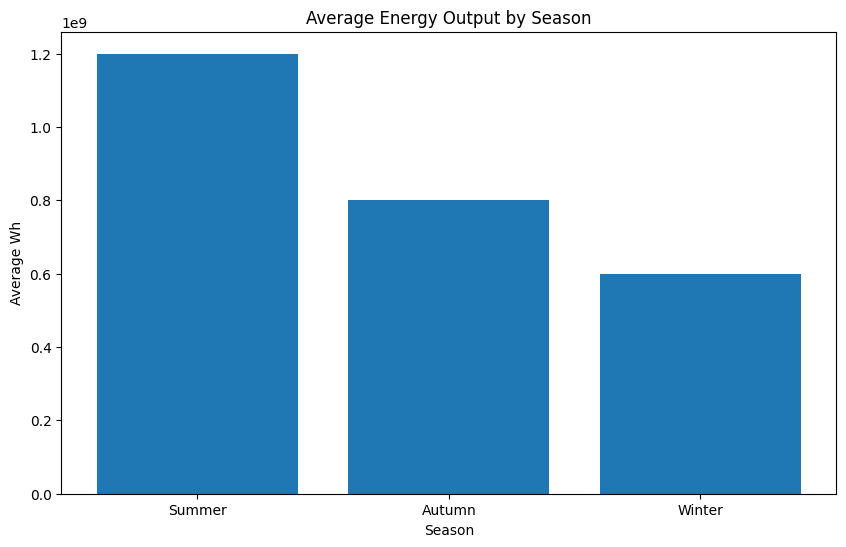

In [1]:
import matplotlib.pyplot as plt

# Adjusted data for the chart as per your request
seasons = ['Summer', 'Autumn', 'Winter']  
average_output = [1.2e9, 0.8e9, 0.6e9]  

# Plotting the bar chart with updated labels and values
plt.figure(figsize=(10, 6))
plt.bar(seasons, average_output)
plt.title('Average Energy Output by Season')
plt.xlabel('Season')
plt.ylabel('Average Wh')
plt.show()